# Challenge: Hyperbolic Embedding via Graph Learning
Authors: Rishi Sonthalia and Xinyue Cui

## 1 Introduction

Many different types of datasets are better represented in hyperbolic space as compared to Euclidean space. These are normally datasets that have semantically rich hierarchies such as text [35], social and other forms of networks [7,9,25,26], and cell development trees [16]. Other applications of hyperbolic representations have also been seen to be useful for computer vision and for other tasks [32,33,34]. Based off of the success of these applications, recently there has been great effort in developing hyperbolic versions of different neural networks - hyperbolic deep neural networks [4,39,46,47], hyperbolic convolutional neural networks [47,48], hyperbolic recurrent neural networks [39], hyperbolic transformers [40,47], and hyperbolic graph neural networks [42,43,45]. See survey [49] for many for example applications.  

Additionally, people have looked at extending hyperbolic embeddings beyong hyperbolic manifolds to other hyperbolic structures such as Hierarchical Hyperbolic Spaces [38]. Work such as [36,37] have proven that phylogentic data live in these Hierarchical Hyperbolic Spaces.


To take advantage of hyperbolic representations we need techniques that learn embed data into hyperbolic manifolds. Historiocally two different approaches have been taken to learning these embeddings. First, we learn these embeddings by solving an optimization problem. This could be done in a supervised on an unsupervised manner. Second, we learn combinatorial structures that are then combinatorially embedded into the hyperbolic manifold.

### 1.1 Optimiation Based Methods. 

For unsupervised method, we are given a distance matrix or a distance matrix is extracted from the given data and then we set up an optimization problem that learns the embedding into the hyperbolic manifold. Concretely, let $D \in \mathbb{R}^{n \times n}$ be the distance matrix, let $y_i$ for $i = 1, \ldots, n$ be the vectors in the hyperbolic manifold $\mathbb{H}^d$. Then we have a loss function $L := L(D, y_1, \ldots, y_n)$ that we want to minimize. Examples of such methods include [2,4,17,18,41]. 

Supervised methods are methods that learn embeddings using neural networks. One common example is to learn work embeddings, works such as [50,51] present hyperbolic versions of standard word embedding techniques such as Word2Vec and GLoVe. Another approach to pick a random vector in $\mathbb{H}^d$ as the initial embedding and this embedding is optimized during the training of the neural network. 

However, such approaches tend to have a few common issues. 

    1) The optimization problem is non convex and is very difficult to solve;
    2) the otpimiation procedure is unstable and require large number of bits to accruately represent; or
    3) the methods ignore the geometry of the input data;
    4) the methods do not have any theoretical gaurantees. 
    
### 1.2 Combinatorial Techniques. 

There also many combinatorial methods. These certain around two different technqiues. The first is to directly embed a given graph into a hyperbolic manifold []. Other methods exploit the tree like structure [] of hyperbolic space. For these methods, given a metric, we first learn a tree that approximates the given metric []. Then given this tree we either treat the tree as the hyperbolic representation or embed the tree in a hyperbolic manifold using Sarkars algorithms and its extensions []. 

### 1.3 This Notebook

In this notebook, we would like to implement one such combinatorial method. Specifically, we present the latest tree learning method [] as well as Sarkars algorithm []. The structure of the notebook will be as follows

     1) First we present some background on hyperbolic geometry from both the differential and algebraic view point
     2) We present TreeRep and demonstrate how it can be used to construct trees from metrics
     3) We present Sarkars algorithm and demonstrate how it can be used to embed data into hyperbolic disk. 
     4) We test the complete pipeline on real world and synthetic datasets to demonstrate that we get embeddings with low distortion. 
 
Other implementations of the above algorithms exist. TreeRep has two prior implementations. The first is in Julia and can be found at [] and the second in C++ and can be found at []. There are two prior implementations of Sarkars algorithm as well. Again there are in Julia [] and in C++ []. Both implementations for both algorithms have python wrappers. But to the best of our knowledge there does not exist a python version of the two algorithms. 


### 1.4 Related work

There is another family of work related to these methods. That is idea of approximating general metrics by trees. Note here we do not have hyperbolic view of these metrics or of the trees just that trees are simple graphical structures. Such work includes []

The final area of related work, is this the notion of metric embeddings and includes work such as []. 

# 3 Code 

In [1]:
# Import the necessary packages
import sys

In [2]:
%%capture
!{sys.executable} -m pip install networkx numpy scipy torch geomstats mpmath
!{sys.executable} -m pip install -U matplotlib

import time
import numpy as np
import networkx as nx
import geomstats.backend as gs
from geomstats.geometry.poincare_ball import PoincareBallMetric
from geomstats.geometry.poincare_ball import PoincareBall
from geomstats.datasets.prepare_graph_data import Graph

In [3]:
import TreeRepresentation
import embedding_mpmath
import TreeSpace
import utilities
import prior

import matplotlib.pyplot as plt

## 2.1 TreeRep - Reconstructing Trees. 


The first example that we look at is given a metric from a Tree can we reconstruct the original tree from the metric. In the code below, we 

    1) use networkx to sample a random tree on $n$ nodes and then extract its metric. Lines 6 - 13
    2) reconstruct the tree using TreeRep. Line 14
    3) print the distortion for the learned tree. Line 15

As we can see from the output our distortion is small (should be less than $10^{-15}$). We then plot the original graph and reconstructed graph side by side to show that we have actually recovered the original tree. 

The distortion between the original metric and the reconstructed metric is:  3.1345958559250546e-18



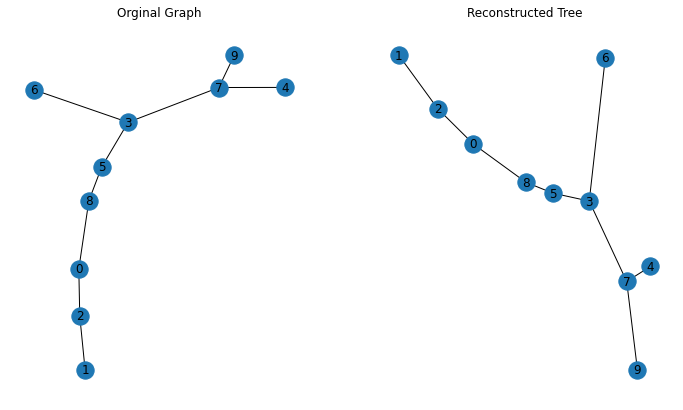

In [4]:
n = 10
G = nx.random_tree(n)
for e in G.edges():
    G[e[0]][e[1]]['weight'] = gs.random.rand()*10
d = nx.algorithms.shortest_paths.dense.floyd_warshall(G)
D = gs.zeros((n,n))
for i in range(n):
  for j in range(n):
    D[i,j] = d[i][j]
T = TreeSpace.TreeSpace(d = D)
print("The distortion between the original metric and the reconstructed metric is: ",T.distortion())
print()

fig, ax = plt.subplots(1, 2, figsize=(12, 7))
nx.draw(G, ax = ax[0], with_labels = True, pos=nx.spring_layout(G, weight='weight'))
nx.draw(T.T.G, ax = ax[1], with_labels = True, pos=nx.spring_layout(T.T.G, weight='weight'))

ax[0].set_title("Orginal Graph")
ax[1].set_title("Reconstructed Tree");

Note that the TreeRep algorithm only requies a metric and does not require the orginal metric to come from a Tree it could have come from anywhere. Here we show an example of input that came from a complete graph and then a sparse graph. Note the complete graph is a not a tree but defines a tree metric

The distortion between the original metric and the reconstructed metric is:  0.0



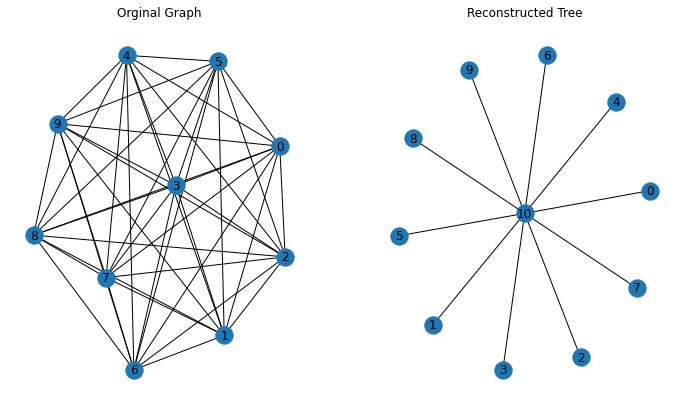

In [5]:
n = 10
G = nx.complete_graph(n)
for e in G.edges():
    G[e[0]][e[1]]['weight'] = 1
d = nx.algorithms.shortest_paths.dense.floyd_warshall(G)
D = gs.zeros((n,n))
for i in range(n):
  for j in range(n):
    D[i,j] = d[i][j]
T = TreeSpace.TreeSpace(d = D)
print("The distortion between the original metric and the reconstructed metric is: ",T.distortion())
print()

fig, ax = plt.subplots(1, 2, figsize=(12, 7))
nx.draw(G, ax = ax[0], with_labels = True, pos=nx.spring_layout(G, weight='weight'))
nx.draw(T.T.G, ax = ax[1], with_labels = True, pos=nx.spring_layout(T.T.G, weight='weight'))

ax[0].set_title("Orginal Graph")
ax[1].set_title("Reconstructed Tree");

The distortion between the original metric and the reconstructed metric is:  0.2668344278319204



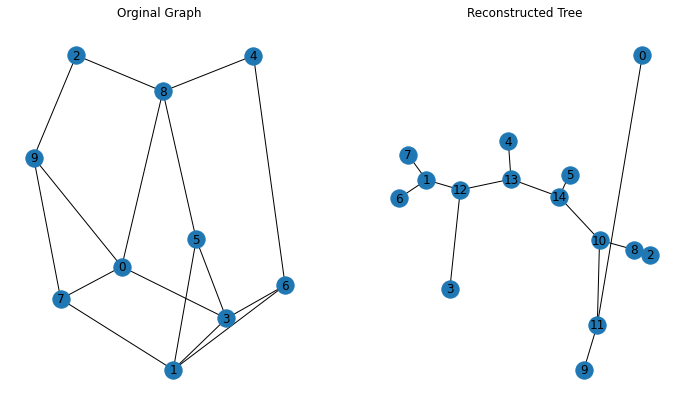

In [6]:
n = 10
G = nx.gnp_random_graph(n,0.35)
for e in G.edges():
    G[e[0]][e[1]]['weight'] = gs.random.rand()*10
d = nx.algorithms.shortest_paths.dense.floyd_warshall(G)
D = gs.zeros((n,n))
for i in range(n):
  for j in range(n):
    D[i,j] = d[i][j]
T = TreeSpace.TreeSpace(d = D)
print("The distortion between the original metric and the reconstructed metric is: ",T.distortion())
print()

fig, ax = plt.subplots(1, 2, figsize=(12, 7))
nx.draw(G, ax = ax[0], with_labels = True, pos=nx.spring_layout(G, weight='weight'))
nx.draw(T.T.G, ax = ax[1], with_labels = True, pos=nx.spring_layout(T.T.G, weight='weight'))

ax[0].set_title("Orginal Graph")
ax[1].set_title("Reconstructed Tree");

### Benchmarking Time

Here we run some experiments to benchmarck the time taken for this implementation. 

Text(0, 0.5, 'Time Taken in seconds')

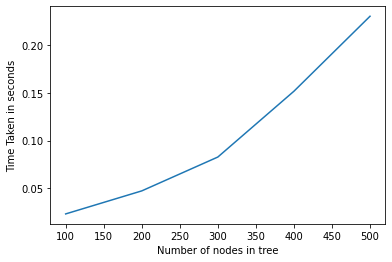

In [8]:
num_n = 5

times = np.zeros(num_n)

for n in range(100,(num_n+1)*100,100):
  G = nx.random_tree(n)
  for e in G.edges():
      G[e[0]][e[1]]['weight'] = gs.random.rand()*10
  d = nx.algorithms.shortest_paths.dense.floyd_warshall(G)
  D = gs.zeros((n,n))
  for i in range(n):
    for j in range(n):
      D[i,j] = d[i][j]
  t0 = time.time()
  T = TreeSpace.TreeSpace(d = D)
  t1 = time.time()
  times[(n-100)//100] = t1-t0
plt.plot(range(100,(num_n+1)*100,100), times)
plt.xlabel("Number of nodes in tree")
plt.ylabel("Time Taken in seconds")

## 3.2 Sarkars Algorithm

Now that we have our method for learning trees. The next step in the pipeline is to embbed the trees into the Poincare disk. For this we shall use Sarkar's algorithm. 

Sarkar's algorithm says that if $D$ is a metric from a tree. Then for every $\epsilon > 0$, there exists a $\tau > 0$ such that $\tau D $ can be embedded into the Poincare disk with $\epsilon$ distortion. 

Note that decreasing $\epsilon$ results in increasing $\tau$. This pushes the embedding points closer to the edge of the disk and hence we could run into nummerical precision issues. 

To begin let us take a simple tree $T$ and view its embedding in the Poincare disk for different values of $\epsilon$. We can also calculate the distortion between the embedded data points and the original metric. 

The distortion between the original metric and the reconstructed metric is:  8.07514980977745e-17



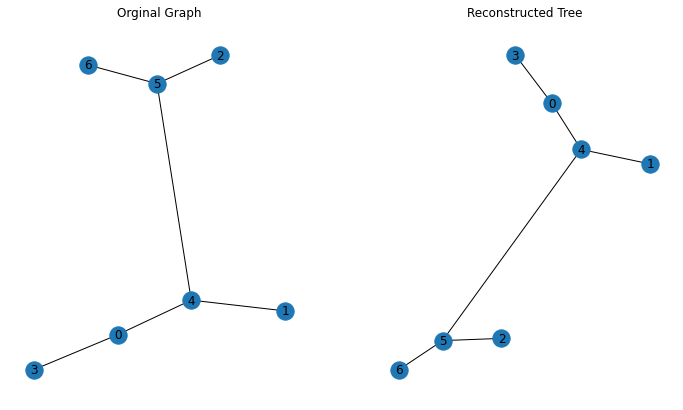

In [12]:
n = 7
G = nx.random_tree(n)
for e in G.edges():
    G[e[0]][e[1]]['weight'] = gs.random.rand()
d = nx.algorithms.shortest_paths.dense.floyd_warshall(G)
D = gs.zeros((n,n))
for i in range(n):
  for j in range(n):
    D[i,j] = d[i][j]
T = TreeSpace.TreeSpace(d = D)
print("The distortion between the original metric and the reconstructed metric is: ",T.distortion())
print()

fig, ax = plt.subplots(1, 2, figsize=(12, 7))
nx.draw(G, ax = ax[0], with_labels = True, pos=nx.spring_layout(G, weight='weight'))
nx.draw(T.T.G, ax = ax[1], with_labels = True, pos=nx.spring_layout(T.T.G, weight='weight'))

ax[0].set_title("Orginal Graph")
ax[1].set_title("Reconstructed Tree");

Here we will directly vary $\tau$ to see how this effects the embedding both visually and in terms of the metric obtained. As we can see from the figure below, as we increase $\tau$ the data points get pushed more towards the boundary of the disk. We can also see that as $\tau$ increases, the distortion between the original metric and the embedded metric decreases. 

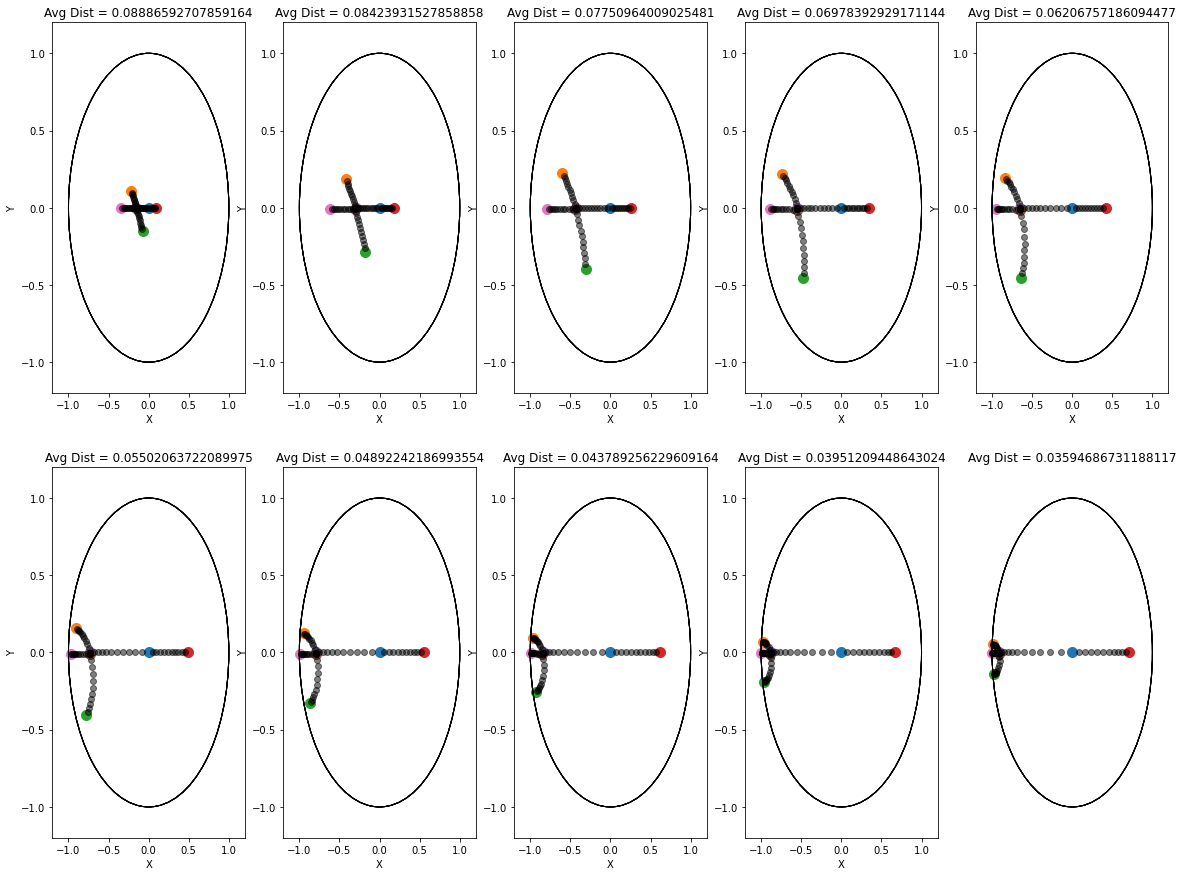

In [17]:
T = TreeSpace.TreeSpace(d = D)
fig, ax = plt.subplots(2, 5, figsize=(20, 15))
for i in range(1,11):
  if i <= 5:
    idx1 = 0
    idx2 = i-1
  else:
    idx1 = 1
    idx2 = i-6
  T.embed_to_poincare_ball(tau = i/2)
  T.visualize(ax[idx1,idx2], tau = i/2)
  ax[idx1,idx2].set_title("Avg Dist = "+str(T.distortion("Input - embed")))

## 3.3 Testing on Synthetic test

We are now going to perform tests on synthetic examples for the following experiments

    1) Dimensionality reduction on hyperbolic manifold
    2) Embeddings graphs 
    

### 3.3.1 Random Points on the hyperbolic manifold

In [18]:
ds = range(100,1001,100)
for d in ds:
  n = 200
  Hd = PoincareBall(d)
  HdMetric = PoincareBallMetric(d)

  X = Hd.random_point(n,1)

  D = gs.zeros((n,n))
  for i in range(n):
    for j in range(i):
      D[i,j] = HdMetric.dist(X[i,:], X[j,:])
      D[j,i] = D[i,j]

  t0 = time.time()
  T = TreeSpace.TreeSpace(d = D)
  t1 = time.time()

  lt = t1-t0

  t0 = time.time()
  T.embed_to_poincare_ball(tau = 1)
  t1 = time.time()

  print("Reducing from dimension ", d)
  print("The distortion between the original metric and the tree metric is: ",T.distortion())
  print("Tree Learned in ", lt, " seconds")
  print("The distortuon between the original metric and the embedded metric is: ",T.distortion("Input - embed"))
  print("Embedding learned in ",t1-t0, " seconds")
  print()

Reducing from dimension  100
The distortion between the original metric and the tree metric is:  0.07887086404936347
Tree Learned in  0.04200124740600586  seconds
The distortuon between the original metric and the embedded metric is:  0.2843706792044817
Embedding learned in  0.19386601448059082  seconds

Reducing from dimension  200
The distortion between the original metric and the tree metric is:  0.040310937171303
Tree Learned in  0.045461177825927734  seconds
The distortuon between the original metric and the embedded metric is:  0.26641801727159486
Embedding learned in  0.18504714965820312  seconds

Reducing from dimension  300
The distortion between the original metric and the tree metric is:  0.03872994591414914
Tree Learned in  0.04142045974731445  seconds
The distortuon between the original metric and the embedded metric is:  0.25449749614611117
Embedding learned in  0.186112642288208  seconds

Reducing from dimension  400
The distortion between the original metric and the tre

### 3.3.2 Random Sparse Graphs

In [19]:
Ns = range(100,401,100)
for n in Ns:
  G = nx.gnp_random_graph(n,0.5)
  for e in G.edges():
      G[e[0]][e[1]]['weight'] = gs.random.rand()*10
  d = nx.algorithms.shortest_paths.dense.floyd_warshall(G)
  D = gs.zeros((n,n))
  for i in range(n):
    for j in range(n):
      D[i,j] = d[i][j]
  t0 = time.time()
  T = TreeSpace.TreeSpace(d = D)
  t1 = time.time()

  lt = t1-t0

  t0 = time.time()
  T.embed_to_poincare_ball(tau = 1)
  t1 = time.time()

  print("GNP graph with n = ", n)
  print("The distortion between the original metric and the tree metric is: ",T.distortion())
  print("Tree Learned in ", lt, " seconds")
  print("The distortuon between the original metric and the embedded metric is: ",T.distortion("Input - embed"))
  print("Embedding learned in ",t1-t0, " seconds")
  print()

GNP graph with n =  100
The distortion between the original metric and the tree metric is:  0.3934314931231371
Tree Learned in  0.020526409149169922  seconds
The distortuon between the original metric and the embedded metric is:  0.34679294644568054
Embedding learned in  0.06665706634521484  seconds

GNP graph with n =  200
The distortion between the original metric and the tree metric is:  0.56388064872473
Tree Learned in  0.03717803955078125  seconds
The distortuon between the original metric and the embedded metric is:  0.4363343191549289
Embedding learned in  0.1486809253692627  seconds

GNP graph with n =  300
The distortion between the original metric and the tree metric is:  0.7758086037388714
Tree Learned in  0.05469322204589844  seconds
The distortuon between the original metric and the embedded metric is:  0.4161332364125552
Embedding learned in  0.2113480567932129  seconds

GNP graph with n =  400
The distortion between the original metric and the tree metric is:  0.44158588

## 3.4 Testing it on real world data

In [20]:
from geomstats.datasets.utils import load_karate_graph

In [21]:
karate_graph = load_karate_graph()
kg = nx.Graph()

for k in karate_graph.edges:
  N = karate_graph.edges[k]
  for v in N:
    kg.add_edge(k,v)

The distortion between the original metric and the reconstructed metric is:  0.2591800356506238
Tree Learned in  0.005649566650390625  seconds



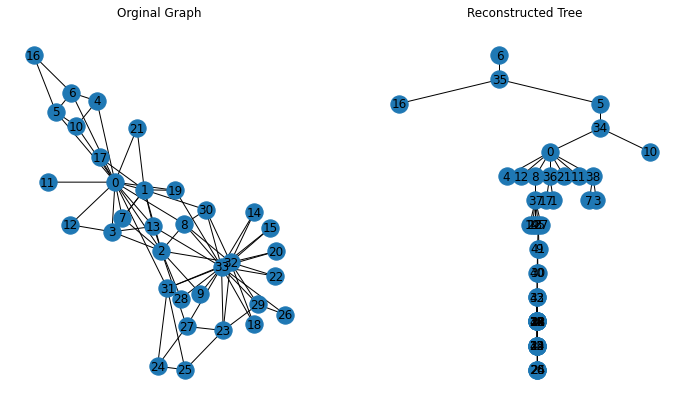

In [23]:
n = karate_graph.n_nodes
d = nx.algorithms.shortest_paths.dense.floyd_warshall(kg)
D = gs.zeros((n,n))
for i in range(n):
  for j in range(n):
    D[i,j] = d[i][j]
t0 = time.time()
T = TreeSpace.TreeSpace(d = D)
t1 = time.time()

lt = t1-t0
print("The distortion between the original metric and the reconstructed metric is: ",T.distortion())
print("Tree Learned in ", lt, " seconds")
print()

fig, ax = plt.subplots(1, 2, figsize=(12, 7))
nx.draw(kg, ax = ax[0], with_labels = True, pos=nx.spring_layout(kg, weight='weight'))
nx.draw(T.T.G, ax = ax[1], with_labels = True, pos=utilities.hierarchy_pos(T.T.G))

ax[0].set_title("Orginal Graph")
ax[1].set_title("Reconstructed Tree");

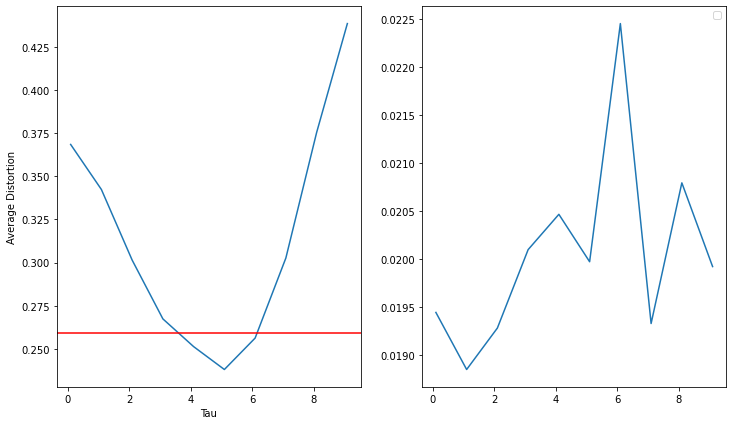

In [24]:
distorts = gs.zeros(10)
taus = gs.zeros(10)

average_embed_time = gs.zeros(10)

for i in range(1,101,10):
  t0 = time.time()
  T.embed_to_poincare_ball(tau = i/10)
  t1 = time.time()
  average_embed_time[i//10] = t1-t0
  distorts[i//10] = T.distortion("Input - embed")
  taus[i//10] = i/10


fig, ax = plt.subplots(1, 2, figsize=(12, 7))
ax[0].plot(taus, distorts, label = "Input metric and embedded metric distortion")
ax[0].axhline(y = T.distortion(), color = "red", label = "Input data and tree distortion")
ax[0].set_xlabel("Tau")
ax[0].set_ylabel("Average Distortion")
plt.legend()

ax[1].plot(taus, average_embed_time)

This is extremely fast and produces a good quality embedding in under 0.06 seconds.



In [26]:
karate_graph = load_karate_graph()
embeddings = prior.compute(karate_graph)

100%|██████████| 100/100 [01:01<00:00,  1.64it/s]

Optimization done in  61.15235638618469  seconds


In [27]:
METRIC = PoincareBallMetric(2)
P2 = PoincareBall(2)

n = karate_graph.n_nodes
distances = gs.zeros((n,n))
for i in range(n):
  for j in range(i):
    distances[i,j] = METRIC.dist(embeddings[i,:], embeddings[j,:])
    distances[j,i] = distances[i,j]

In [28]:
D_new = distances
D_old = D

dist = 0
for i in range(n):
  for j in range(i):
    dist += gs.abs(D_new[i,j]-D_old[i,j])/D_old[i,j]
2*dist/(n*(n-1))

0.29624635699259266

### CS Ph.D. Graph. 

This is a bigger example that better highlights the advantages of the new method

In [29]:
cs_graph = Graph("CSphd.csv", None)
cs = nx.Graph()

for k in cs_graph.edges:
  N = cs_graph.edges[k]
  for v in N:
    cs.add_edge(k,v)

In [ ]:
n = cs_graph.n_nodes

d = nx.algorithms.shortest_paths.dense.floyd_warshall(cs)
D = gs.zeros((n,n))
for i in range(n):
  for j in range(n):
    D[i,j] = d[i][j]
t0 = time.time()
T = TreeSpace.TreeSpace(d = D)
t1 = time.time()

lt = t1-t0
print("The distortion between the original metric and the reconstructed metric is: ",T.distortion())
print("Tree Learned in ", lt, " seconds")
print()

#fig, ax = plt.subplots(1, 2, figsize=(12, 7))
#nx.draw(cs, ax = ax[0], with_labels = True, pos=nx.spring_layout(cs, weight='weight'))
#nx.draw(T.T.G, ax = ax[1], with_labels = True, pos=utilities.hierarchy_pos(T.T.G))

#ax[0].set_title("Orginal Graph")
#ax[1].set_title("Reconstructed Tree");

In [ ]:
distorts = gs.zeros(10)
taus = gs.zeros(10)

average_embed_time = gs.zeros(10)

for i in range(1,101,10):
  t0 = time.time()
  T.embed_to_poincare_ball(tau = i/50)
  t1 = time.time()
  average_embed_time[i//10] = t1-t0
  distorts[i//10] = T.distortion("Input - embed")
  taus[i//10] = i/10


fig, ax = plt.subplots(1, 2, figsize=(12, 7))
ax[0].plot(taus, distorts, label = "Input metric and embedded metric distortion")
ax[0].axhline(y = T.distortion(), color = "red", label = "Input data and tree distortion")
ax[0].set_xlabel("Tau")
ax[0].set_ylabel("Average Distortion")
plt.legend()

ax[1].plot(taus, average_embed_time)

In [ ]:
cs_graph = Graph("CSphd.csv", None)
embeddings = prior.compute(cs_graph)

In [ ]:
METRIC = PoincareBallMetric(2)
P2 = PoincareBall(2)

distances = gs.zeros((n,n))
for i in range(n):
  for j in range(i):
    distances[i,j] = METRIC.dist(embeddings[i,:], embeddings[j,:])
    distances[j,i] = distances[i,j]

In [ ]:
D_new = distances
D_old = D

dist = 0
for i in range(n):
  for j in range(i):
    dist += gs.abs(D_new[i,j]-D_old[i,j])/D_old[i,j]
2*dist/(n*(n-1))

# Bibliograph

[1] Thomas Blasius, Tobias Friedrich, Anton Krohmer, Soren Laue, Anton Krohmer, Soren Laue, Tobias Friedrich, and Thomas Blasius. 2018. Efficient Embedding of Scale-Free Graphs in the Hyperbolic Plane. IEEE/ACM Trans. Netw. 26, 2 (April 2018), 920–933. DOI:https://doi.org/10.1109/TNET.2018.2810186 
 
 [2] Cvetkovski, Andrej and Crovella, Mark (2016) "Multidimensional Scaling in the Poincaré disk," Applied Mathematics & Information Sciences: Vol. 10 : Iss. 1 , Article 12. 
 DOI: http://dx.doi.org/10.18576/amis/100112 
 Available at: https://dc.naturalspublishing.com/amis/vol10/iss1/12 
 
 [3] Kevin Verbeek and Subhash Suri. 2014. Metric Embedding, Hyperbolic Space, and Social Networks. In Proceedings of the thirtieth annual symposium on Computational geometry (SOCG'14). Association for Computing Machinery, New York, NY, USA, 501–510. DOI:https://doi.org/10.1145/2582112.2582139 
 
 [4] Jörg A Walter, H-MDS: a new approach for interactive visualization with multidimensional scaling in the hyperbolic space, Information Systems, Volume 29, Issue 4, 2004, Pages 273-292, ISSN 0306-4379, https://doi.org/10.1016/j.is.2003.10.002. 
 
 [5] R. Kleinberg. 2007. Geographic Routing Using Hyperbolic Space. In Proceedings of the IEEE INFOCOM 2007 - 26th IEEE International Conference on Computer Communications. IEEE Computer Society, USA, 1902–1909. DOI:https://doi.org/10.1109/INFCOM.2007.221 
 
 [6] R. Krauthgamer and J. R. Lee, "Algorithms on negatively curved spaces," 2006 47th Annual IEEE Symposium on Foundations of Computer Science (FOCS'06), 2006, pp. 119-132, doi: 10.1109/FOCS.2006.9. 
 
 [7] Krioukov D, Papadopoulos F, Vahdat A, Boguñá M. Curvature and temperature of complex networks. Phys Rev E Stat Nonlin Soft Matter Phys. 2009 Sep;80(3 Pt 2):035101. doi: 10.1103/PhysRevE.80.035101. Epub 2009 Sep 23. PMID: 19905164. 
 
 [8] A. Cvetkovski and M. Crovella, "Hyperbolic Embedding and Routing for Dynamic Graphs," IEEE INFOCOM 2009, 2009, pp. 1647-1655, doi: 10.1109/INFCOM.2009.5062083. 
 
 [9] Y. Shavitt and T. Tankel, "Hyperbolic Embedding of Internet Graph for Distance Estimation and Overlay Construction," in IEEE/ACM Transactions on Networking, vol. 16, no. 1, pp. 25-36, Feb. 2008, doi: 10.1109/TNET.2007.899021. 
 
 [10] Matthias Hamann. On the Tree-Likeness of Hyperbolic Spaces. Mathematical Proceedings of the Cambridge Philosophical Society, 164(2):345–361, 2018. doi: 10.1017/ S0305004117000238. 
 
 [11] Anna Dyubina and Iosif Polterovich. Explicit Constructions of Universal R-Trees and Asymptotic Geometry of Hyperbolic Spaces. Bulletin of the London Mathematical Society, 33 (6):727?734, Nov 2001. 
 
 [12] M.Bonk and O.Schramm. Embeddings of Gromov Hyperbolic Spaces. Geometric & Functional Analysis GAFA, 10(2):266–306, Jun 2000. 
 
 [13] Ittai Abraham, Mahesh Balakrishnan, Fabian Kuhn, Dahlia Malkhi, Venugopalan Ramasubramanian, and Kunal Talwar. Reconstructing Approximate Tree Metrics. In Proceedings of the Twenty-sixth Annual ACM Symposium on Principles of Distributed Computing, PODC ’07, pages 43–52, New York, NY, USA, 2007. ACM. 
 
 [14] M.R. Bridson and A. Häfliger. Metric Spaces of Non-Positive Curvature. Grundlehren der mathematischen Wissenschaften. Springer Berlin Heidelberg, 2013. ISBN 9783662124949. 
 
 [15] Victor Chepoi, Feodor Dragan, Bertrand Estellon, Michel Habib, and Yann Vaxès. Diameters, Centers, and Approximating Trees of δ-Hyperbolic Geodesic Spaces and Graphs. In Proceedings of the Twenty-fourth Annual Symposium on Computational Geometry, SCG ’08, pages 59–68, New York, NY, USA, 2008. ACM. 
 
 [16] Anna Klimovskaia, David Lopez-Paz, Léon Bottou, and Maximilian Nickel. Poincaré Maps for Analyzing complex Hierarchies in Single-Cell Data. bioRxiv, 2019. doi: 10.1101/689547. 
 
 [17] Maximilian Nickel and Douwe Kiela. Poincaré Embeddings for Learning Hierarchical Representations. In NIPS, 2017. 
 
 [18] Frederic Sala, Chris De Sa, Albert Gu, and Christopher Re. Representation Tradeoffs for Hy- perbolic Embeddings. Proceedings of the 35th International Conference on Machine Learning, pages 4460–4469, July 2018. 
 
 [19] Rik Sarkar. Low Distortion Delaunay Embedding of Trees in Hyperbolic Plane. In Proceedings of the 19th International Conference on Graph Drawing, GD’11, pages 355–366, Berlin, Heidelberg, 2012. Springer-Verlag. 
 
 [20] B. P. Chamberlin, J. Clough, and M. P. Deisenroth, "Neural embeddings of graphs in hyperbolic space", arXiv 2017
 
 [21] M. E. Newman, “Power laws, pareto distributions and zipf’s law,” Contemporary physics, 2005.

 [22] H. W. Lin and M. Tegmark, “Critical behavior in physics and probabilistic formal languages,” Entropy, 2017.

 [23] K. Katayama and E. W. Maina, “Indexing method for hierarchical graphs based on relation among interlacing sequences of eigenvalues,” Journal of information processing, 2015.

 [24] R. Shimizu, Y. Mukuta, and T. Harada, “Hyperbolic neural networks++,” 2021.
 
 [25] M. Boguna ́, F. Papadopoulos, and D. Krioukov, “Sustaining the internet with hyperbolic mapping,” Nature communications, 2010.

 [26] B. Tadic ́, M. Andjelkovic ́, and M. Sˇuvakov, “Origin of hyperbolicity in brain-to-brain coordination networks,” Frontiers in Physics, 2018.
 
 [27] G.Garcia-Pe ́rez,M.Bogun ̃a ́,A.Allard,andM.A ́.Serrano,“Thehidden hyperbolic geometry of international trade: World trade atlas 1870– 2013,” Scientific reports, 2016.

 [28] M. Keller-Ressel and S. Nargang, “The hyperbolic geometry of financial networks,” Scientific reports, 2021.
 
 [29] R. Krauthgamer and J. R. Lee, “Algorithms on negatively curved spaces,” in 2006 47th Annual IEEE Symposium on Foundations of Computer Science (FOCS’06). IEEE, 2006.

 [30] E. Begelfor and M. Werman, “The world is not always flat or learning curved manifolds,” School of Engineering and Computer Science, Hebrew University of Jerusalem., Tech. Rep, 2005.

 [31] M. M. Bronstein, J. Bruna, Y. LeCun, A. Szlam, and P. Vandergheynst, “Geometric deep learning: going beyond euclidean data,” IEEE Signal Processing Magazine, 2017.
 
 [32] B. P. Chamberlain, S. R. Hardwick, D. R. Wardrope, F. Dzogang, F. Daolio, and S. Vargas, “Scalable hyperbolic recommender systems,” CoRR, 2019.

 [33] P. Kolyvakis, A. Kalousis, and D. Kiritsis, “Hyperkg: hyperbolic knowledge graph embeddings for knowledge base completion,” arXiv, 2019.

 [34] V. Khrulkov, L. Mirvakhabova, E. Ustinova, I. Oseledets, and V. Lempit- sky, “Hyperbolic image embeddings,” in Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition, 2020.
 
 [35] Bhuwan Dhingra, Christopher J. Shallue, Mohammad Norouzi, Andrew M. Dai, and George E. Dahl. Embedding Text in Hyperbolic Spaces, 2018.
 
 [36] Louis J. Billera, Susan P. Holmes, and Karen Vogtmann. Geometry of the space of phylogenetic trees. Advances in Applied Mathematics, 27(4):733–767, 2001. ISSN 0196-8858. doi: https:// doi.org/10.1006/aama.2001.0759. URL https://www.sciencedirect.com/science/ article/pii/S0196885801907596.
 
 [37] Katherine St John. Review paper: The shape of phylogenetic treespace. Systematic Biology, 66:e83 – e94, 2017.
 
 [38] CubeRep: Learning Relations Between Different Views of Data. 
 
 [39] O. Ganea, G. Be ́cigneul, and T. Hofmann, “Hyperbolic neural networks,” Advances in neural information processing systems, 2018.

 [40] C. Gulcehre, M. Denil, M. Malinowski, A. Razavi, R. Pascanu, K. M. Hermann, P. Battaglia, V. Bapst, D. Raposo, A. Santoro et al., “Hyperbolic attention networks,” arXiv, 2018.

 [41] M. Nickel and D. Kiela, “Learning continuous hierarchies in the lorentz model of hyperbolic geometry,” Proceedings of the 35-th International Conference on Machine Learning, PMLR, 2018.

 [42] Q. Liu, M. Nickel, and D. Kiela, “Hyperbolic graph neural networks,” in Advances in Neural Information Processing Systems, 2019.

 [43] I. Chami, Z. Ying, C. Re ́, and J. Leskovec, “Hyperbolic graph convolutional neural networks,” in Advances in neural information processing systems, 2019.

 [44] W. Peng, J. Shi, Z. Xia, and G. Zhao, “Mix dimension in poincare ́ geometry for 3d skeleton-based action recognition,” in Proceedings of the 28th ACM International Conference on Multimedia, 2020.

 [45] G. Bachmann, G. Be ́cigneul, and O. Ganea, “Constant curvature graph convolutional networks,” in International Conference on Machine Learning. PMLR, 2020.

 [46] D. J. Rezende, G. Papamakarios, S. Racaniere, M. S. Albergo, G. Kanwar, P. E. Shanahan, and K. Cranmer, “Normalizing flows on tori and spheres,” Proceedings of the 37th International Conference on Machine Learning, 2020.
 
 [47] Chen, W., Han, X., Lin, Y., Zhao, H., Liu, Z., Li, P., Sun, M., & Zhou, J. (2021). Fully Hyperbolic Neural Networks. ArXiv, abs/2105.14686.
 
 [48] Lensink, K., Haber, E., & Peters, B. (2019). Fully Hyperbolic Convolutional Neural Networks. ArXiv, abs/1905.10484.
 
 [50] Leimeister, M., & Wilson, B.J. (2018). Skip-gram word embeddings in hyperbolic space. ArXiv, abs/1809.01498.
 
 [51] Tifrea, A., Bécigneul, G., & Ganea, O. (2019). Poincaré GloVe: Hyperbolic Word Embeddings. ArXiv, abs/1810.06546.